In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [5]:
dataset1 = pd.read_csv('dalas/project/githubProject/ConflictPrediction/dataset1/dataset1_beforeSplit.csv')

# TRAITEMENT SUR LE DATASET 1 (MASKED)

## Split en train/test

In [6]:
## Code pour split le dataset 1 en train/test 90-10 %

X = dataset1.drop(columns=['war'])
y = dataset1['war']

# Split train/test final
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=0.1,# 10% pour test
    stratify=y, #pour garder la répartition des classes
    random_state=42 #pour mettre une random seed fixe
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (6610, 221)
Test shape: (735, 221)


## Entraînement XGBoost avec StratifiedKFold + scores

-- Fold 0 --
Accuracy : 0.9682
Precision: 0.9556
Recall   : 0.9663
F1-score : 0.9609
F1-score (train): 1.0000
-- Fold 1 --
Accuracy : 0.9713
Precision: 0.9769
Recall   : 0.9513
F1-score : 0.9639
F1-score (train): 1.0000
-- Fold 2 --
Accuracy : 0.9713
Precision: 0.9662
Recall   : 0.9625
F1-score : 0.9644
F1-score (train): 1.0000
-- Fold 3 --
Accuracy : 0.9667
Precision: 0.9623
Recall   : 0.9551
F1-score : 0.9586
F1-score (train): 1.0000
-- Fold 4 --
Accuracy : 0.9682
Precision: 0.9767
Recall   : 0.9438
F1-score : 0.9600
F1-score (train): 1.0000
-- Fold 5 --
Accuracy : 0.9697
Precision: 0.9805
Recall   : 0.9436
F1-score : 0.9617
F1-score (train): 1.0000
-- Fold 6 --
Accuracy : 0.9682
Precision: 0.9588
Recall   : 0.9624
F1-score : 0.9606
F1-score (train): 1.0000
-- Fold 7 --
Accuracy : 0.9743
Precision: 0.9844
Recall   : 0.9511
F1-score : 0.9675
F1-score (train): 1.0000
-- Fold 8 --
Accuracy : 0.9667
Precision: 0.9692
Recall   : 0.9474
F1-score : 0.9582
F1-score (train): 1.0000
-- Fold 9 

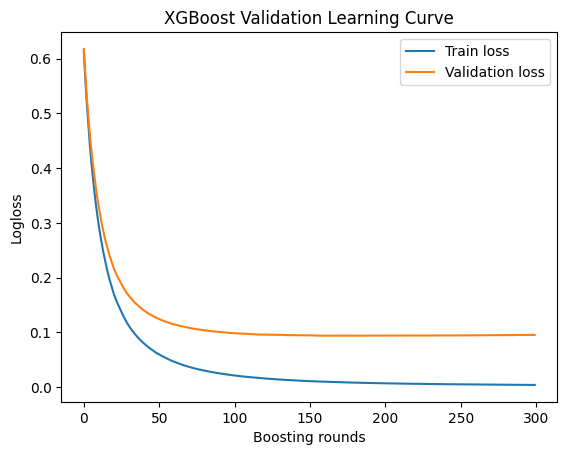

In [ ]:
def pipeline_stratifiedKFold_and_training_XGBoost(X_train,y_train,k=10):
    list_accuracy_scores = []
    list_precision_scores = []
    list_recall_scores = []
    list_f1_scores = []
    list_f1_train_scores = []
    train_losses = []
    val_losses = []
    skf = StratifiedKFold(n_splits=k, shuffle=True,random_state=42) # shuffle pour mélanger les données avant de split 

    for i,(train_index,val_index) in enumerate(skf.split(X_train, y_train)):

        # On récupère les sous-datasets d'entraînement et de validation
        X_tr = X_train.iloc[train_index]
        X_val=  X_train.iloc[val_index]
        y_tr  = y_train.iloc[train_index] 
        y_val = y_train.iloc[val_index]

        print(f"-- Fold {i} --")
        
        # Maintenant on entraine et évalue le modèle avec X_tr, y_tr, X_val, y_val

        # Modèle XGBoost
        model = xgb.XGBClassifier( # Hyperparamètres à voir
            n_estimators=300,
            max_depth=7,
            learning_rate=0.1,
            colsample_bytree=1.0,
            subsample=0.8,
            random_state=42,
            eval_metric="logloss"
        )
         

        # Entraînement
        eval_set = [(X_tr, y_tr), (X_val, y_val)]
        model.fit(
            X_tr, y_tr,
            eval_set=eval_set,
            verbose=False
        )

        results = model.evals_result()
        train_loss = results['validation_0']['logloss']
        val_loss = results['validation_1']['logloss']

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Prédiction sur le set de validation
        y_pred = model.predict(X_val)

        # Prédiction sur le set de train  (pour vérifier l'overfitting)
        y_train_pred = model.predict(X_tr)

        # Métriques
        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred)
        rec = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred) # la plus importante
        f1_train = f1_score(y_tr, y_train_pred)

        list_accuracy_scores.append(acc)
        list_precision_scores.append(prec)
        list_recall_scores.append(rec)
        list_f1_scores.append(f1)
        list_f1_train_scores.append(f1_train)

        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1-score : {f1:.4f}")
        print(f"F1-score (train): {f1_train:.4f}")

    # Moyenne et écart-type pour chaque métrique
    avg_acc, std_acc = np.mean(list_accuracy_scores), np.std(list_accuracy_scores)
    avg_prec, std_prec = np.mean(list_precision_scores), np.std(list_precision_scores)
    avg_rec, std_rec = np.mean(list_recall_scores), np.std(list_recall_scores)
    avg_f1, std_f1 = np.mean(list_f1_scores), np.std(list_f1_scores)
    avg_f1_train, std_f1_train = np.mean(list_f1_train_scores), np.std(list_f1_train_scores)

    print(f"\nAverage metrics over {k} folds:")
    print(f"Accuracy  : {avg_acc:.4f} ± {std_acc:.4f}")
    print(f"Precision : {avg_prec:.4f} ± {std_prec:.4f}")
    print(f"Recall    : {avg_rec:.4f} ± {std_rec:.4f}")
    print(f"F1-score  : {avg_f1:.4f} ± {std_f1:.4f}")
    print(f"F1-score (train): {avg_f1_train:.4f} ± {std_f1_train:.4f}")

    mean_train_loss = np.mean([np.array(l) for l in train_losses], axis=0)
    mean_val_loss = np.mean([np.array(l) for l in val_losses], axis=0)

    plt.plot(mean_train_loss, label="Train loss")
    plt.plot(mean_val_loss, label="Validation loss")
    plt.xlabel("Boosting rounds")
    plt.ylabel("Logloss")
    plt.title("XGBoost Validation Learning Curve")
    plt.legend()
    plt.show()

    return ((avg_acc, std_acc), (avg_prec, std_prec), (avg_rec, std_rec), (avg_f1, std_f1), (avg_f1_train, std_f1_train),(list_f1_train_scores, list_f1_scores))

((avg_acc_xgb, std_acc_xgb), 
 (avg_prec_xgb, std_prec_xgb), 
 (avg_rec_xgb, std_rec_xgb), 
 (avg_f1_xgb, std_f1_xgb),
 (avg_f1_train_xgb, std_f1_train_xgb),
 (list_f1_train_scores_xgb, list_f1_scores_xgb)) = pipeline_stratifiedKFold_and_training_XGBoost(X_train, y_train, k=10)

In [13]:
# Définition du modèle
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Définition de la grille de paramètres à tester
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Stratified K-Fold pour garder la proportion des classes
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Scorer : ici on optimise le F1-score
f1_scorer = make_scorer(f1_score)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=skf,
    verbose=1,
    n_jobs=-1
)

# Lancement du tuning
grid_search.fit(X_train, y_train)

# Résultats
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur F1-score :", grid_search.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/Users/raphaelmalidin/Documents/masterMIND/M1/S1/mapsi/tme/4_tme/tme04/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [12:46:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/raphaelmalidin/Documents/masterMIND/M1/S1/mapsi/tme/4_tme/tme04/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [12:46:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/raphaelmalidin/Documents/masterMIND/M1/S1/mapsi/tme/4_tme/tme04/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [12:46:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/raphaelmalidin/Documents/masterMIND/M1/S1/mapsi/

Meilleurs paramètres : {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Meilleur F1-score : 0.9620776334548455


## Entraînement LightGBM avec StratifiedKFold + scores

In [ ]:
# Fonction de nettoyage des noms de colonnes pour LightGBM
def clean_feature_names(df):
    df = df.copy()
    df.columns = df.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)
    return df

def pipeline_stratifiedKFold_and_training_LGBM(X_train, y_train, k=10):

    X_train = clean_feature_names(X_train)

    list_accuracy_scores = []
    list_precision_scores = []
    list_recall_scores = []
    list_f1_scores = []
    list_f1_train_scores = []
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    for i, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):

        # Récupération des sous-ensembles
        X_tr = X_train.iloc[train_index]
        X_val = X_train.iloc[val_index]
        y_tr = y_train.iloc[train_index]
        y_val = y_train.iloc[val_index]

        print(f"-- Fold {i} --")

        # Modèle LightGBM
        model = lgb.LGBMClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=-1,
            num_leaves=31,
            random_state=42,
            verbose=0
        )

        # Entraînement
        model.fit(X_tr, y_tr)

        # Prédiction
        y_pred = model.predict(X_val)
        y_train_pred = model.predict(X_tr)

        # Métriques
        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred)
        rec = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        f1_train = f1_score(y_tr, y_train_pred)

        list_accuracy_scores.append(acc)
        list_precision_scores.append(prec)
        list_recall_scores.append(rec)
        list_f1_scores.append(f1)
        list_f1_train_scores.append(f1_train)

        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1-score : {f1:.4f}")
        print(f"F1-score (train): {f1_train:.4f}")

    # Moyenne et écart-type pour chaque métrique
    avg_acc, std_acc = np.mean(list_accuracy_scores), np.std(list_accuracy_scores)
    avg_prec, std_prec = np.mean(list_precision_scores), np.std(list_precision_scores)
    avg_rec, std_rec = np.mean(list_recall_scores), np.std(list_recall_scores)
    avg_f1, std_f1 = np.mean(list_f1_scores), np.std(list_f1_scores)
    avg_f1_train, std_f1_train = np.mean(list_f1_train_scores), np.std(list_f1_train_scores)

    print("\nAverage metrics over {} folds:".format(k))
    print(f"Accuracy  : {avg_acc:.4f} ± {std_acc:.4f}")
    print(f"Precision : {avg_prec:.4f} ± {std_prec:.4f}")
    print(f"Recall    : {avg_rec:.4f} ± {std_rec:.4f}")
    print(f"F1-score  : {avg_f1:.4f} ± {std_f1:.4f}")
    print(f"F1-score (train): {avg_f1_train:.4f} ± {std_f1_train:.4f}")
    print(f"Difference F1 train - F1 val: {avg_f1_train - avg_f1:.4f}")

    return ((avg_acc, std_acc), (avg_prec, std_prec), (avg_rec, std_rec), (avg_f1, std_f1), (avg_f1_train, std_f1_train))

((avg_acc_lgb, std_acc_lgb),
 (avg_prec_lgb, std_prec_lgb),
 (avg_rec_lgb, std_rec_lgb),
 (avg_f1_lgb, std_f1_lgb),
 (avg_f1_train_lgb, std_f1_train_lgb)) = pipeline_stratifiedKFold_and_training_LGBM(X_train, y_train, k=10)

-- Fold 0 --
Accuracy : 0.9667
Precision: 0.9588
Recall   : 0.9588
F1-score : 0.9588
F1-score (train): 1.0000
-- Fold 1 --
Accuracy : 0.9652
Precision: 0.9692
Recall   : 0.9438
F1-score : 0.9564
F1-score (train): 1.0000
-- Fold 2 --
Accuracy : 0.9713
Precision: 0.9627
Recall   : 0.9663
F1-score : 0.9645
F1-score (train): 1.0000
-- Fold 3 --
Accuracy : 0.9622
Precision: 0.9583
Recall   : 0.9476
F1-score : 0.9529
F1-score (train): 1.0000
-- Fold 4 --
Accuracy : 0.9682
Precision: 0.9767
Recall   : 0.9438
F1-score : 0.9600
F1-score (train): 1.0000
-- Fold 5 --
Accuracy : 0.9728
Precision: 0.9806
Recall   : 0.9511
F1-score : 0.9656
F1-score (train): 1.0000
-- Fold 6 --
Accuracy : 0.9697
Precision: 0.9659
Recall   : 0.9586
F1-score : 0.9623
F1-score (train): 1.0000
-- Fold 7 --
Accuracy : 0.9758
Precision: 0.9845
Recall   : 0.9549
F1-score : 0.9695
F1-score (train): 1.0000
-- Fold 8 --
Accuracy : 0.9682
Precision: 0.9730
Recall   : 0.9474
F1-score : 0.9600
F1-score (train): 1.0000
-- Fold 9 

## Entraînement CatBoost avec StratifiedKFold + scores

In [ ]:
def pipeline_stratifiedKFold_and_training_CatBoost(X_train, y_train, k=10):

    list_accuracy_scores = []
    list_precision_scores = []
    list_recall_scores = []
    list_f1_scores = []
    list_f1_train_scores = []
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    for i, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):

        # Récupération des sous-ensembles
        X_tr = X_train.iloc[train_index]
        X_val = X_train.iloc[val_index]
        y_tr = y_train.iloc[train_index]
        y_val = y_train.iloc[val_index]

        print(f"Fold {i}")

        # Modèle CatBoost
        model = CatBoostClassifier(
            iterations=300,
            learning_rate=0.05,
            depth=6, # équivalent à ~num_leaves mais plus stable
            loss_function="Logloss",
            eval_metric="F1",
            random_seed=42,
            verbose=False
        )

        # Entraînement
        model.fit(X_tr, y_tr)

        # Prédiction
        y_pred = model.predict(X_val)
        y_train_pred = model.predict(X_tr)

        # Métriques
        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred)
        rec = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        f1_train = f1_score(y_tr, y_train_pred)

        list_accuracy_scores.append(acc)
        list_precision_scores.append(prec)
        list_recall_scores.append(rec)
        list_f1_scores.append(f1)
        list_f1_train_scores.append(f1_train)

        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1-score : {f1:.4f}")
        print(f"F1-score (train): {f1_train:.4f}")
        print(f"Difference F1 train - F1 val: {avg_f1_train - avg_f1:.4f}")

    # Moyenne et écart-type pour chaque métrique
    avg_acc, std_acc = np.mean(list_accuracy_scores), np.std(list_accuracy_scores)
    avg_prec, std_prec = np.mean(list_precision_scores), np.std(list_precision_scores)
    avg_rec, std_rec = np.mean(list_recall_scores), np.std(list_recall_scores)
    avg_f1, std_f1 = np.mean(list_f1_scores), np.std(list_f1_scores)
    avg_f1_train, std_f1_train = np.mean(list_f1_train_scores), np.std(list_f1_train_scores)

    print("\nAverage metrics over {} folds:".format(k))
    print(f"Accuracy  : {avg_acc:.4f} ± {std_acc:.4f}")
    print(f"Precision : {avg_prec:.4f} ± {std_prec:.4f}")
    print(f"Recall    : {avg_rec:.4f} ± {std_rec:.4f}")
    print(f"F1-score  : {avg_f1:.4f} ± {std_f1:.4f}")
    print(f"F1-score (train): {avg_f1_train:.4f} ± {std_f1_train:.4f}")

    return ((avg_acc, std_acc), (avg_prec, std_prec), (avg_rec, std_rec), (avg_f1, std_f1), (avg_f1_train, std_f1_train))

((avg_acc_cb, std_acc_cb),
 (avg_prec_cb, std_prec_cb),
 (avg_rec_cb, std_rec_cb), 
 (avg_f1_cb, std_f1_cb), 
 (avg_f1_train_cb, std_f1_train_cb)) = pipeline_stratifiedKFold_and_training_CatBoost(X_train, y_train, k=10)

Fold 0
Accuracy : 0.9667
Precision: 0.9554
Recall   : 0.9625
F1-score : 0.9590
F1-score (train): 0.9880
Fold 1
Accuracy : 0.9592
Precision: 0.9688
Recall   : 0.9288
F1-score : 0.9484
F1-score (train): 0.9876
Fold 2
Accuracy : 0.9758
Precision: 0.9772
Recall   : 0.9625
F1-score : 0.9698
F1-score (train): 0.9865
Fold 3
Accuracy : 0.9607
Precision: 0.9547
Recall   : 0.9476
F1-score : 0.9511
F1-score (train): 0.9884
Fold 4
Accuracy : 0.9667
Precision: 0.9842
Recall   : 0.9326
F1-score : 0.9577
F1-score (train): 0.9861
Fold 5
Accuracy : 0.9637
Precision: 0.9764
Recall   : 0.9323
F1-score : 0.9538
F1-score (train): 0.9885
Fold 6
Accuracy : 0.9697
Precision: 0.9624
Recall   : 0.9624
F1-score : 0.9624
F1-score (train): 0.9874
Fold 7
Accuracy : 0.9667
Precision: 0.9766
Recall   : 0.9398
F1-score : 0.9579
F1-score (train): 0.9857
Fold 8
Accuracy : 0.9576
Precision: 0.9577
Recall   : 0.9361
F1-score : 0.9468
F1-score (train): 0.9863
Fold 9
Accuracy : 0.9667
Precision: 0.9692
Recall   : 0.9474
F1-

## Entraînement Random Forest avec StratifiedKFold + scores

In [ ]:
def pipeline_stratifiedKFold_and_training_RF(X_train, y_train, k=10):

    list_accuracy_scores = []
    list_precision_scores = []
    list_recall_scores = []
    list_f1_scores = []
    list_f1_train_scores = []
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    for i, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):

        # Récupération des sous-ensembles
        X_tr = X_train.iloc[train_index]
        X_val = X_train.iloc[val_index]
        y_tr = y_train.iloc[train_index]
        y_val = y_train.iloc[val_index]

        print(f"Fold {i}")

        # Modèle RandomForest
        model = RandomForestClassifier(
            n_estimators=300, # en ligne avec LGBM/CatBoost
            max_depth=None, # laisse l’arbre croître (fort sur F1)
            min_samples_split=2,
            min_samples_leaf=1,
            class_weight="balanced", # Essentiel pour le dataset 60/40
            random_state=42,
            n_jobs=-1
        )

        # Entraînement
        model.fit(X_tr, y_tr)

        # Prédiction
        y_pred = model.predict(X_val)
        y_train_pred = model.predict(X_tr)

        # Métriques
        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred)
        rec = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        f1_train = f1_score(y_tr, y_train_pred)

        list_accuracy_scores.append(acc)
        list_precision_scores.append(prec)
        list_recall_scores.append(rec)
        list_f1_scores.append(f1)
        list_f1_train_scores.append(f1_train)

        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1-score : {f1:.4f}")
        print(f"F1-score (train): {f1_train:.4f}")

    # Moyenne et écart-type pour chaque métrique
    avg_acc, std_acc = np.mean(list_accuracy_scores), np.std(list_accuracy_scores)
    avg_prec, std_prec = np.mean(list_precision_scores), np.std(list_precision_scores)
    avg_rec, std_rec = np.mean(list_recall_scores), np.std(list_recall_scores)
    avg_f1, std_f1 = np.mean(list_f1_scores), np.std(list_f1_scores)
    avg_f1_train, std_f1_train = np.mean(list_f1_train_scores), np.std(list_f1_train_scores)

    print("\nAverage metrics over {} folds:".format(k))
    print(f"Accuracy  : {avg_acc:.4f} ± {std_acc:.4f}")
    print(f"Precision : {avg_prec:.4f} ± {std_prec:.4f}")
    print(f"Recall    : {avg_rec:.4f} ± {std_rec:.4f}")
    print(f"F1-score  : {avg_f1:.4f} ± {std_f1:.4f}")
    print(f"F1-score (train): {avg_f1_train:.4f} ± {std_f1_train:.4f}")
    print(f"Difference F1 train - F1 val: {avg_f1_train - avg_f1:.4f}")

    return ((avg_acc, std_acc), (avg_prec, std_prec), (avg_rec, std_rec), (avg_f1, std_f1), (avg_f1_train, std_f1_train))

((avg_acc_rf, std_acc_rf),
 (avg_prec_rf, std_prec_rf),
 (avg_rec_rf, std_rec_rf),
 (avg_f1_rf, std_f1_rf),
 (avg_f1_train_rf, std_f1_train_rf)) = pipeline_stratifiedKFold_and_training_RF(X_train, y_train, k=10)

Fold 0
Accuracy : 0.9697
Precision: 0.9557
Recall   : 0.9700
F1-score : 0.9628
F1-score (train): 1.0000
Fold 1
Accuracy : 0.9682
Precision: 0.9805
Recall   : 0.9401
F1-score : 0.9598
F1-score (train): 1.0000
Fold 2
Accuracy : 0.9697
Precision: 0.9660
Recall   : 0.9588
F1-score : 0.9624
F1-score (train): 1.0000
Fold 3
Accuracy : 0.9622
Precision: 0.9618
Recall   : 0.9438
F1-score : 0.9527
F1-score (train): 1.0000
Fold 4
Accuracy : 0.9743
Precision: 0.9808
Recall   : 0.9551
F1-score : 0.9677
F1-score (train): 1.0000
Fold 5
Accuracy : 0.9652
Precision: 0.9765
Recall   : 0.9361
F1-score : 0.9559
F1-score (train): 1.0000
Fold 6
Accuracy : 0.9637
Precision: 0.9618
Recall   : 0.9474
F1-score : 0.9545
F1-score (train): 1.0000
Fold 7
Accuracy : 0.9697
Precision: 0.9767
Recall   : 0.9474
F1-score : 0.9618
F1-score (train): 1.0000
Fold 8
Accuracy : 0.9682
Precision: 0.9767
Recall   : 0.9436
F1-score : 0.9598
F1-score (train): 1.0000
Fold 9
Accuracy : 0.9682
Precision: 0.9880
Recall   : 0.9323
F1-

## Tableau recapitulatif

In [27]:
data = {
        'Model': ['XGBoost', 'LightGBM', 'CatBoost', 'RandomForest'],
        'Accuracy (avg ± std)': [f"{avg_acc_xgb:.4f} ± {std_acc_xgb:.4f}",
                                f"{avg_acc_lgb:.4f} ± {std_acc_lgb:.4f}",
                                f"{avg_acc_cb:.4f} ± {std_acc_cb:.4f}",
                                f"{avg_acc_rf:.4f} ± {std_acc_rf:.4f}"],
        'Precision (avg ± std)': [f"{avg_prec_xgb:.4f} ± {std_prec_xgb:.4f}",
                                f"{avg_prec_lgb:.4f} ± {std_prec_lgb:.4f}",
                                f"{avg_prec_cb:.4f} ± {std_prec_cb:.4f}",
                                f"{avg_prec_rf:.4f} ± {std_prec_rf:.4f}"],
        'Recall (avg ± std)': [f"{avg_rec_xgb:.4f} ± {std_rec_xgb:.4f}",
                        f"{avg_rec_lgb:.4f} ± {std_rec_lgb:.4f}",
                        f"{avg_rec_cb:.4f} ± {std_rec_cb:.4f}",
                        f"{avg_rec_rf:.4f} ± {std_rec_rf:.4f}"],
        'F1-score (avg ± std)': [f"{avg_f1_xgb:.4f} ± {std_f1_xgb:.4f}",
                                f"{avg_f1_lgb:.4f} ± {std_f1_lgb:.4f}",
                                f"{avg_f1_cb:.4f} ± {std_f1_cb:.4f}",
                                f"{avg_f1_rf:.4f} ± {std_f1_rf:.4f}"]
}

df = pd.DataFrame(data)
df

,Model,Accuracy (avg ± std),Precision (avg ± std),Recall (avg ± std),F1-score (avg ± std)
0,XGBoost,0.9626 ± 0.0047,0.9648 ± 0.0088,0.9418 ± 0.0127,0.9531 ± 0.0060
1,LightGBM,0.9687 ± 0.0037,0.9706 ± 0.0087,0.9512 ± 0.0079,0.9608 ± 0.0046
2,CatBoost,0.9654 ± 0.0051,0.9683 ± 0.0098,0.9452 ± 0.0127,0.9565 ± 0.0065
3,RandomForest,0.9675 ± 0.0033,0.9724 ± 0.0099,0.9463 ± 0.0104,0.9591 ± 0.0041
